In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

### Get Electricity Load Forecasts

Data from https://www.eia.gov/opendata/qb.php?category=2122627
- NYISO
- MISO
- PJM
- "Other" regions

In [67]:
# Load in data for 'Other' and save it to a csv 
cple_df = pd.read_csv('load_forecasts/other/CPLE.csv', parse_dates = [0], index_col = 0)
cplw_df = pd.read_csv('load_forecasts/other/CPLW.csv', parse_dates = [0], index_col = 0)
duk_df = pd.read_csv('load_forecasts/other/DUK.csv', parse_dates = [0], index_col = 0)
lgee = pd.read_csv('load_forecasts/other/LGEE.csv', parse_dates = [0], index_col = 0)
ovec_df = pd.read_csv('load_forecasts/other/OVEC.csv', parse_dates = [0], index_col = 0)
tva_df = pd.read_csv('load_forecasts/other/TVA.csv', parse_dates = [0], index_col = 0)

In [68]:
other_df = pd.concat([cple_df,cplw_df, duk_df, lgee, ovec_df, tva_df], axis=1)
other_df.to_csv('load_forecasts/other.csv') 

In [69]:
# Load all forecast data 
other_df = pd.read_csv('load_forecasts/other.csv', parse_dates = [0])
miso_df = pd.read_csv('load_forecasts/MISO.csv', parse_dates = [0])
nyiso_df = pd.read_csv('load_forecasts/NYISO.csv', parse_dates = [0])

nyiso_df.columns = ['Date', 'NYISO']
miso_df.columns = ['Date', 'MISO']
other_df.columns = ['Date', 'CPLE', 'CPLW', 'DUK', 'LGEE', 'OVEC', 'TVA']

In [70]:
# PJM Load Data 
pjm_df = pd.concat(map(pd.read_csv, ['load_forecasts/pjm/2016.csv', 'load_forecasts/pjm/2017.csv','load_forecasts/pjm/2018.csv']))
pjm_df = pjm_df.drop(['evaluated_at_utc', 'evaluated_at_ept', 'forecast_hour_beginning_ept'], axis = 1)
pjm_df.columns = ['Date', 'area', 'PJM']

In [71]:
pjm_df = pjm_df.groupby( ['Date', 'area'] ).mean().reset_index()

In [72]:
# Pivot so each area of PJM is a separate column 
pjm_df = pjm_df.pivot_table(values=['PJM'], index=['Date'], columns='area')
pjm_df.columns = pjm_df.columns.map('|'.join).str.strip('|')
pjm_df = pjm_df.reset_index()
pjm_df['Date'] = pd.to_datetime(pjm_df['Date'])

### Fill in Missing Values
- Take average of value before and after

In [73]:
def keep_year(df, year_arr):
    df = df.copy(deep=True)
    return df[df['Date'].dt.year.isin(year_arr)]

In [74]:
years = [2016, 2017, 2018]
miso_df = keep_year(miso_df, years)
nyiso_df = keep_year(nyiso_df, years)
other_df = keep_year(other_df, years)

In [75]:
# Fill missing values 
other_df = other_df.set_index('Date')
other_df = (other_df.ffill()+other_df.bfill())/2
other_df = other_df.bfill().ffill()
other_df = other_df.reset_index()

pjm_df = pjm_df.set_index('Date')
pjm_df = (pjm_df.ffill()+pjm_df.bfill())/2
pjm_df = pjm_df.bfill().ffill()
pjm_df = pjm_df.reset_index()

In [76]:
# Sum the "other" columns into one 
other_df = other_df.dropna()
other_df = other_df.set_index('Date')
other_df['other']=other_df.sum(axis=1)
other_df = other_df[['other']]
other_df = other_df.reset_index()

### Combine Load Data from All Regions 

In [77]:
# Include load data from all regions 
load_nyiso = pjm_df.merge(nyiso_df, on = 'Date')
load_nyiso = load_nyiso.merge(miso_df, on = 'Date')
load_nyiso = load_nyiso.merge(other_df, on = 'Date')

In [78]:
load_nyiso

,Date,PJM|AEP,PJM|APS,PJM|ATSI,PJM|COMED,PJM|DAY,PJM|DEOK,PJM|DOM,PJM|DUQ,PJM|EKPC,PJM|MIDATL,PJM|RTO,NYISO,MISO,other
0,2016-01-01 10:00:00,12950.333333,5188.833333,6259.000000,9650.833333,1700.166667,2743.300000,8816.500000,1359.500000,1577.200000,25102.833333,75272.833333,13243,66190,32824.0
1,2016-01-01 22:00:00,15995.333333,6361.666667,7970.500000,11396.666667,2073.000000,3279.000000,11483.666667,1699.166667,1740.300000,33931.666667,95852.666667,17068,72717,38030.0
2,2016-01-01 11:00:00,13477.000000,5390.500000,6410.000000,9862.666667,1746.333333,2846.200000,9236.500000,1412.166667,1634.700000,26077.166667,77986.500000,13374,67087,33831.0
3,2016-01-01 23:00:00,16176.166667,6457.666667,8159.000000,12089.166667,2149.000000,3376.700000,11609.500000,1712.666667,1823.200000,34053.333333,97530.166667,18405,75753,40662.0
4,2016-01-01 12:00:00,13897.666667,5403.500000,6613.500000,10120.500000,1793.500000,2926.200000,9562.166667,1450.500000,1687.900000,26858.000000,80204.333333,13582,68608,35150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26270,2018-09-09 19:00:00,14014.000000,5072.375000,6920.125000,9769.000000,1733.750000,2951.250000,12701.000000,1407.500000,1528.750000,27921.125000,84018.875000,16073,71945,50131.0
26271,2018-09-09 08:00:00,10501.166667,3889.333333,5460.333333,7906.666667,1321.500000,2159.833333,8587.666667,1135.166667,1059.333333,21699.833333,63720.833333,12900,58581,34194.0
26272,2018-09-09 20:00:00,14150.444444,5151.777778,6989.333333,9839.000000,1741.888889,2951.000000,12721.666667,1414.333333,1522.555556,28348.333333,84830.333333,16036,72479,51014.0
26273,2018-09-09 09:00:00,10570.166667,3936.333333,5508.333333,7864.666667,1333.500000,2167.833333,8613.666667,1142.166667,1061.333333,21905.333333,64103.333333,12779,57803,33418.0


### Get DateTime Information 

In [79]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

In [80]:
load_nyiso = extract_date(load_nyiso, 'Date')
load_nyiso = load_nyiso.sort_values(by=['year', 'month', 'day', 'hour'])
load_nyiso = load_nyiso.set_index(['year', 'month', 'day', 'hour'])

### Get Import / Export Data
From https://dataminer2.pjm.com/feed/da_interface_flows_and_limits/definition (day ahead forecasts)

In [81]:
df = pd.concat(map(pd.read_csv, ['import_exports/2016.csv', 'import_exports/2017.csv','import_exports/2018.csv']))

# just look at actual flow for now
df = df.drop(['datetime_ending_utc', 'datetime_ending_ept', 'inadv_flow', 'sched_flow'], axis=1)

isorto_df = df.groupby( ['datetime_beginning_utc'] ).sum().reset_index()

In [82]:
isorto_df

,datetime_beginning_utc,actual_flow
0,1/1/2016 10:00:00 AM,831.602
1,1/1/2016 10:00:00 PM,3447.558
2,1/1/2016 11:00:00 AM,1629.002
3,1/1/2016 11:00:00 PM,2819.978
4,1/1/2016 12:00:00 PM,2380.883
...,...,...
26299,9/9/2018 7:00:00 PM,-4977.485
26300,9/9/2018 8:00:00 AM,-5421.333
26301,9/9/2018 8:00:00 PM,-4759.991
26302,9/9/2018 9:00:00 AM,-5808.149


In [83]:
isorto_df.columns = ['Date', 'mwh']
isorto_df['Date'] = pd.to_datetime(isorto_df['Date'])
isorto_df = extract_date(isorto_df, 'Date')

In [84]:
isorto_df = isorto_df.set_index(['year', 'month', 'day', 'hour'])

In [85]:
isorto_df = isorto_df.drop(['Date'], axis=1)

In [86]:
# Combine features and output into the same df so that I have corresponding datapoints 
combined = load_nyiso.merge(isorto_df, how='inner', left_index=True, right_index=True)
target = combined[['mwh']].copy()
features = combined.drop(['mwh'], axis=1)

### Pivot so it's by hour 

In [87]:
target = target.reset_index()
target = target.pivot_table(index = ['year','month', 'day'], columns="hour", values=target.columns)
target.columns = target.columns.map('{0[0]}|{0[1]}'.format)
target = target.dropna()
target

mwh|0     mwh|1     mwh|2     mwh|3     mwh|4     mwh|5  \
year month day                                                               
2016 1     2    2595.602  2696.511  2181.332  1857.976  1475.693   567.266   
           3    2426.938  2368.043  2524.946  2001.349  1240.677   768.735   
           4    2284.681  2478.814  1955.634  1811.527   821.726  1252.547   
           5    3668.677  3095.258  2237.204  2094.617  2208.316  2350.017   
           6    4687.691  4333.211  4241.033  2470.559  1341.839  2091.620   
...                  ...       ...       ...       ...       ...       ...   
2018 12    361 -3093.050 -3090.551 -3271.855 -3384.930 -3791.768 -3817.572   
           362 -2853.446 -3045.288 -3179.324 -3137.343 -2937.823 -4096.085   
           363 -5911.536 -6330.201 -6790.004 -7260.733 -6843.184 -7439.930   
           364 -5732.284 -3654.873 -5841.465 -6191.485 -5994.899 -5442.451   
           365 -5100.765 -4809.859 -4401.427 -4651.735 -3943.178 -3812.681   

                   mwh|6     mwh|7     mwh|8     mwh|9  ...    mwh|14  \
year month day                                          ...             
2016 1     2    1005.384   740.554   369.324   919.239  ...  2327.118   
           3    1120.893  1056.219  1140.732  1089.412  ...  2803.153   
           4    1636.159  1504.434  1303.439  1471.817  ...  4049.580   
           5    1077.151  1342.149  1694.374  1850.011  ...  5213.103   
           6    1968.116  2009.926  2019.037  1936.154  ...  2771.051   
...                  ...       ...       ...       ...  ...       ...   
2018 12    361 -3987.113 -4811.404 -4963.141 -4674.242  ... -2907.050   
           362 -3978.292 -4001.068 -4185.980 -4108.911  ... -3085.936   
           363 -7638.748 -7313.481 -7580.665 -7251.719  ... -6992.563   
           364 -5560.053 -5817.556 -5580.578 -5167.873  ... -5383.071   
           365 -4113.259 -4107.878 -3597.705 -3121.828  ... -3578.349   

                  mwh|15    mwh|16    mwh|17    mwh|18    mwh|19    mwh|20  \
year month day                                                               
2016 1     2    2431.218  2010.133  2239.086  2194.780  1922.487  1831.736   
           3    2500.997  1942.443  1206.222   977.922  1262.087  1335.927   
           4    3542.616  3444.252  3426.971  3833.996  4260.615  4283.627   
           5    4383.510  3178.486  2857.777  2739.720  2747.735  2567.161   
           6    2982.322  2367.003  1810.533  2119.238  1746.802  1814.622   
...                  ...       ...       ...       ...       ...       ...   
2018 12    361 -2705.205 -3275.620 -3424.569 -3423.631 -3789.572 -3864.425   
           362 -4254.272 -4467.186 -5105.941 -4982.791 -5465.676 -5262.098   
           363 -7352.921 -7274.333 -7306.436 -7196.446 -7154.774 -6781.044   
           364 -5091.444 -4725.610 -5095.045 -5158.177 -5102.603 -4942.104   
           365 -3513.591 -3567.390 -3775.191 -3873.694 -3695.678 -3698.414   

                  mwh|21    mwh|22    mwh|23  
year month day                                
2016 1     2    2020.182  2292.137  2438.912  
           3    1966.226  2372.168  2376.412  
           4    4052.830  5350.368  4125.212  
           5    2492.878  4210.368  4409.609  
           6    2614.506  3552.525  3053.609  
...                  ...       ...       ...  
2018 12    361 -3103.385 -2950.336 -3044.647  
           362 -5781.327 -5164.539 -5471.555  
           363 -5770.780 -5439.261 -5848.347  
           364 -4874.718 -5022.021 -5892.168  
           365 -3291.154 -3135.246 -3671.918  

[1093 rows x 24 columns]

In [88]:
features = features.reset_index()
features = features.pivot_table(index = ['year','month', 'day'], columns="hour", values=features.columns)
features.columns = features.columns.map('{0[0]}|{0[1]}'.format)
features = features.dropna()
features

MISO|0   MISO|1   MISO|2   MISO|3   MISO|4   MISO|5   MISO|6  \
year month day                                                                  
2016 1     2    79963.0  80241.0  79140.0  77943.0  76022.0  73012.0  69062.0   
           3    79271.0  79856.0  78950.0  77708.0  75630.0  72953.0  70250.0   
           4    80602.0  81878.0  81112.0  79502.0  77122.0  73994.0  71565.0   
           5    89111.0  90367.0  89456.0  87537.0  84308.0  80208.0  77012.0   
           6    88570.0  89628.0  88771.0  86677.0  83099.0  79136.0  75425.0   
...                 ...      ...      ...      ...      ...      ...      ...   
2018 12    361  75652.0  75931.0  75192.0  73756.0  70986.0  67154.0  64244.0   
           362  75351.0  75196.0  74135.0  72385.0  69536.0  65869.0  65179.0   
           363  79138.0  78633.0  77621.0  76267.0  74082.0  70997.0  68903.0   
           364  77642.0  77713.0  76850.0  75557.0  73482.0  70517.0  68415.0   
           365  76531.0  76918.0  76146.0  74560.0  72043.0  68874.0  66898.0   

                 MISO|7   MISO|8   MISO|9  ...  other|14  other|15  other|16  \
year month day                             ...                                 
2016 1     2    67342.0  66518.0  66138.0  ...   45923.0   46348.0   44768.0   
           3    68434.0  67481.0  66933.0  ...   45764.0   44871.0   42710.0   
           4    70173.0  69580.0  69642.0  ...   52324.0   51406.0   50163.0   
           5    75504.0  74560.0  74335.0  ...   57644.0   55334.0   53298.0   
           6    73919.0  73026.0  72706.0  ...   57725.0   55274.0   52880.0   
...                 ...      ...      ...  ...       ...       ...       ...   
2018 12    361  62034.0  60696.0  60063.0  ...   45255.0   44978.0   44534.0   
           362  62832.0  61448.0  60918.0  ...   37950.0   37991.0   38203.0   
           363  66700.0  65400.0  64762.0  ...   38013.0   39218.0   39396.0   
           364  66279.0  65038.0  64376.0  ...   37519.0   38563.0   38249.0   
           365  64918.0  63814.0  63399.0  ...   36762.0   37351.0   37631.0   

                other|17  other|18  other|19  other|20  other|21  other|22  \
year month day                                                               
2016 1     2     42771.0   40757.0   39149.0   37648.0   37229.0   37814.0   
           3     40775.0   39204.0   37865.0   36909.0   36482.0   37379.0   
           4     49479.0   48501.0   47610.0   46882.0   46565.0   47243.0   
           5     51418.0   49495.0   47925.0   46700.0   46118.0   47202.0   
           6     50614.0   48649.0   47002.0   45562.0   44847.0   45747.0   
...                  ...       ...       ...       ...       ...       ...   
2018 12    361   43654.0   42380.0   41355.0   40594.0   40144.0   40585.0   
           362   38022.0   37450.0   36851.0   36313.0   36017.0   36283.0   
           363   38911.0   37766.0   36689.0   35961.0   35618.0   36024.0   
           364   36950.0   36545.0   35930.0   35438.0   34948.0   35710.0   
           365   37345.0   36545.0   35980.0   35299.0   34957.0   35119.0   

                other|23  
year month day            
2016 1     2     40751.0  
           3     40392.0  
           4     50072.0  
           5     50609.0  
           6     48472.0  
...                  ...  
2018 12    361   42521.0  
           362   38040.0  
           363   37968.0  
           364   38285.0  
           365   36752.0  

[1093 rows x 336 columns]

In [89]:
### Download features here 
features.to_csv('processed_data/features_processed.csv')

In [55]:
# Remove any rows that don't match 
indx = target.index.difference(features.index)
target = target.drop(indx)

### Train / Test Split

In [56]:
def split(df):
    # 80-20 split 
    df = df.copy()
    
    train_pct_index = int(0.8 * len(df))
    X_train, X_test = df[:train_pct_index], df[train_pct_index:]

    return X_train, X_test

In [57]:
X_train, X_test = split(features)
Y_train, Y_test = split(target)

### Circular Encoding of Time Data

In [58]:
# Circular encoding of day of year and month 
def sin_cos_correction(df):
    df = df.reset_index()
    
    df['day_sin'] = np.sin((df['day']-1)*(2.*np.pi/365))
    df['day_cos'] = np.cos((df['day']-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))
    
    df = df.drop(['month', 'day'], axis=1)
    df = df.set_index(['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos'])
    return df

In [59]:
X_train = sin_cos_correction(X_train)
X_test = sin_cos_correction(X_test)

In [60]:
Y_train = sin_cos_correction(Y_train)
Y_test = sin_cos_correction(Y_test)

### Standardize

In [61]:
# Standardize features 
scaler = StandardScaler()
scaler.fit(X_train.values) # fit on training set 

scaled_X_train = scaler.transform(X_train.values)
scaled_X_test = scaler.transform(X_test.values)

# Convert back to df after scaling 
X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)
    

In [63]:
X_train.to_csv("Import_X_Train1.csv")
X_test.to_csv("Import_X_test1.csv")

In [64]:
Y_train.to_csv("Import_y_Train1.csv")
Y_test.to_csv("Import_y_test1.csv")

In [65]:
Y_test.to_csv('date_index.csv')

### Look at Forecast Data

Based on pricing assignment https://www.pjm.com/~/media/etools/exschedule/interface-pricing-point-assignment-methodology.ashx

In [164]:
MISO = ['ALTE', 'ALTW', 'AMIL', 'CIN', 'CWLP', 'IPL', 'MEC', 'MECS', 'NIPS', 'WEC', 'SIGE', 'LAGN', 'MDU']
NYISO = ['HUDS', 'LIND', 'NEPT', 'NYIS']
OTHER = ['CPLE', 'CPLW', 'DUK', 'LGEE', 'OVEC', 'TVA']

In [165]:
isorto = {}
for item in MISO:
    isorto[item] = 'miso'
for item in NYISO:
    isorto[item] = 'nyiso'
for item in OTHER:
    isorto[item] = 'other'

In [459]:
df = pd.concat(map(pd.read_csv, ['import_exports/2016.csv', 'import_exports/2017.csv','import_exports/2018.csv']))

# just look at actual flow for now
df = df.drop(['datetime_ending_utc', 'datetime_ending_ept', 'inadv_flow', 'sched_flow'], axis=1)

df['isorto'] = df['tie_line'].map(isorto)
isorto_df = df.groupby( ['isorto', 'datetime_beginning_utc'] ).sum().reset_index()

In [461]:
isorto_df.columns = ['isorto', 'Date', 'mwh']
isorto_df['Date'] = pd.to_datetime(isorto_df['Date'])
isorto_df = extract_date(isorto_df, 'Date')

In [462]:
isorto_df = isorto_df.pivot_table(values=['mwh'], index=['year', 'month', 'day', 'hour'], columns='isorto')

In [463]:
isorto_df.columns = isorto_df.columns.map('|'.join).str.strip('|')
isorto_df

mwh|miso  mwh|nyiso  mwh|other
year month day hour                                
2016 1     1   5      -1296.0  -1148.605     2219.0
               6      -1559.0   -884.060     2646.0
               7      -1895.0   -900.307     2694.0
               8      -1944.0   -743.666     2687.0
               9      -1842.0   -684.054     2726.0
...                       ...        ...        ...
2019 1     1   0      -3592.0  -1204.122     1753.0
               1      -3613.0  -1241.175     2051.0
               2      -3619.0  -1463.679     2073.0
               3      -3686.0  -1121.887     1942.0
               4      -3958.0  -1255.738     2251.0

[26304 rows x 3 columns]

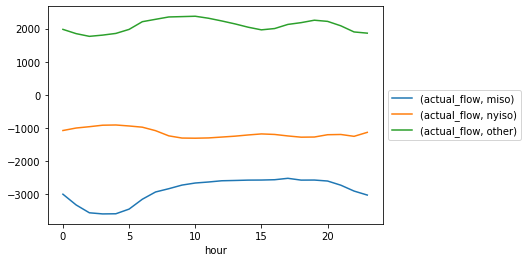

In [208]:
by_hour = isorto_df.groupby( ["hour"] ).mean()
by_hour.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

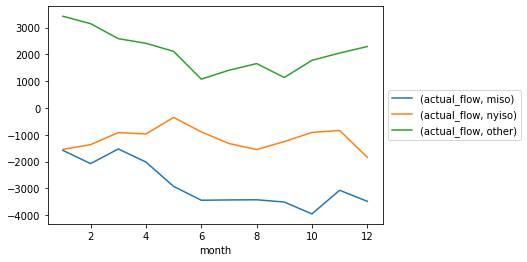

In [209]:
by_month = isorto_df.groupby( ["month"] ).mean()
by_month.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In [190]:
df['datetime_beginning_ept'] = pd.to_datetime(df['datetime_beginning_ept'])
df['month'] = pd.to_datetime(df['datetime_beginning_ept']).dt.month
df['year'] = pd.to_datetime(df['datetime_beginning_ept']).dt.year
df['week'] = pd.to_datetime(df['datetime_beginning_ept']).dt.week
df['day'] = pd.to_datetime(df['datetime_beginning_ept']).dt.day
df['hour'] = pd.to_datetime(df['datetime_beginning_ept']).dt.hour

In [82]:
df_2016 = df.loc[df['year'] == 2016]

In [83]:
df_2016 = df_2016.pivot_table(values=['actual_flow'], index=['month', 'year', 'week', 'day', 'hour'], columns='tie_line')

In [84]:
df_2016.describe()

actual_flow                                                      \
tie_line         ALTE         ALTW         AMIL          CIN         CPLE   
count     8783.000000  8783.000000  8783.000000  8783.000000  8783.000000   
mean      -668.398405  -297.622538   161.232211  -731.854616   531.688649   
std        226.782170   192.634864   865.901389   369.272243   567.347189   
min      -1304.000000  -988.000000 -2850.548000 -1862.000000 -1437.000000   
25%       -834.000000  -432.000000  -496.000000  -986.000000   165.000000   
50%       -693.000000  -293.000000   124.000000  -784.000000   514.000000   
75%       -519.000000  -150.000000   889.453500  -514.500000   872.000000   
max         31.000000   240.000000  2309.000000   761.000000  2328.000000   

                                                                           \
tie_line         CPLW         CWLP          DUK         HUDS          IPL   
count     8783.000000  8783.000000  8783.000000  8783.000000  8783.000000   
mean      -135.242799   -62.218604   302.683024    -8.649587   -94.382216   
std         76.229847    46.516917   326.577350    38.886980   231.112974   
min       -349.000000  -244.000000  -799.000000  -418.428000  -815.000000   
25%       -188.500000   -93.000000    65.000000     0.000000  -248.000000   
50%       -137.000000   -62.000000   298.000000     0.000000  -111.000000   
75%        -85.000000   -32.000000   563.000000     0.000000    52.000000   
max        158.000000   128.000000  1147.000000     0.024000   857.000000   

          ...                                                      \
tie_line  ...         LIND          MEC         MECS         NEPT   
count     ...  8783.000000  8783.000000  8783.000000  8783.000000   
mean      ...  -140.709278  -439.849377  -435.917193  -571.145700   
std       ...   155.445932   231.163403  1168.724197   199.425653   
min       ...  -321.250000 -1432.000000 -4442.000000  -676.000000   
25%       ...  -295.459000  -590.000000 -1189.500000  -673.804000   
50%       ...  -156.168000  -424.000000  -368.000000  -672.150000   
75%       ...    -3.495500  -278.000000   345.500000  -572.000000   
max       ...   307.483000   480.000000  3591.000000     0.113000   

                                                                           \
tie_line         NIPS         NYIS         OVEC         SIGE          TVA   
count     8783.000000  8783.000000  8783.000000  8783.000000  8783.000000   
mean      -927.856655  -276.683187   556.457080    15.382443   785.516061   
std        271.031282   527.004626   568.260836    15.606856   475.105129   
min      -1740.000000 -2166.734000  -554.000000     0.000000  -906.000000   
25%      -1099.000000  -620.034000   140.000000     2.000000   467.000000   
50%       -920.000000  -165.072000   403.000000    10.000000   806.000000   
75%       -748.000000   127.570500   885.500000    25.000000  1126.000000   
max        -47.000000  1088.743000  2792.000000    50.000000  2137.000000   

                       
tie_line          WEC  
count     8783.000000  
mean      1112.720921  
std        539.172821  
min       -524.000000  
25%        714.000000  
50%       1132.000000  
75%       1547.000000  
max       2294.000000  

[8 rows x 22 columns]

In [85]:
by_hour = df_2016.groupby( ["hour"] ).mean()

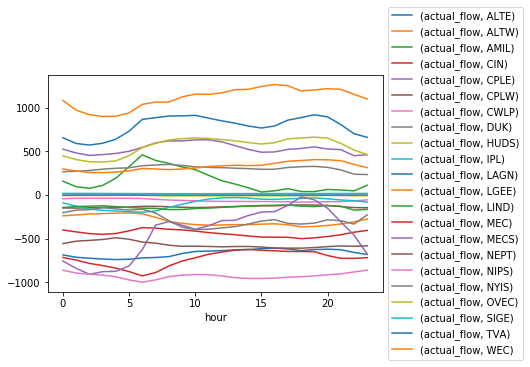

In [86]:
by_hour.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In [87]:
by_month = df_2016.groupby( ["month"] ).mean()

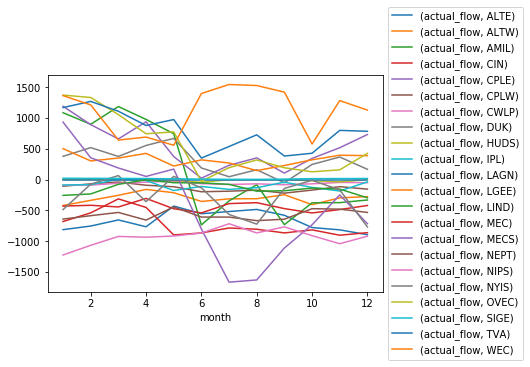

In [88]:
by_month.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In [115]:
df_week = df.loc[df['year'] == 2016]

In [116]:
df_week= df_week.pivot_table(values=['actual_flow'], index=['week', 'datetime_beginning_ept'], columns='tie_line')

In [117]:
df_week = df_week.reset_index()

In [118]:
week1 = df_week.loc[df_week['week'] == 1]

In [119]:
week1

week datetime_beginning_ept actual_flow                         \
tie_line                                    ALTE   ALTW    AMIL     CIN   
0           1    2016-01-04 00:00:00      -839.0 -527.0  1106.0  -410.0   
1           1    2016-01-04 01:00:00      -813.0 -467.0  1097.0  -414.0   
2           1    2016-01-04 02:00:00      -777.0 -465.0   902.0  -355.0   
3           1    2016-01-04 03:00:00      -781.0 -486.0   899.0  -374.0   
4           1    2016-01-04 04:00:00      -744.0 -465.0  1050.0  -426.0   
..        ...                    ...         ...    ...     ...     ...   
163         1    2016-01-10 19:00:00      -666.0 -591.0   907.0  -995.0   
164         1    2016-01-10 20:00:00      -629.0 -559.0   875.0  -990.0   
165         1    2016-01-10 21:00:00      -727.0 -551.0   902.0 -1046.0   
166         1    2016-01-10 22:00:00      -824.0 -562.0   866.0 -1090.0   
167         1    2016-01-10 23:00:00      -783.0 -537.0  1080.0  -986.0   

                                        ...                                  \
tie_line    CPLE   CPLW   CWLP     DUK  ...     LIND    MEC   MECS     NEPT   
0         1078.0 -109.0 -100.0  1007.0  ... -296.438 -852.0  -11.0 -672.624   
1         1117.0 -109.0  -92.0  1058.0  ... -320.372 -848.0  -74.0 -672.491   
2         1127.0 -112.0  -87.0  1067.0  ... -320.961 -856.0 -310.0 -672.492   
3         1109.0 -127.0  -86.0  1048.0  ... -320.962 -838.0 -520.0 -672.520   
4          942.0 -122.0  -86.0   927.0  ... -320.933 -771.0 -505.0 -672.408   
..           ...    ...    ...     ...  ...      ...    ...    ...      ...   
163        519.0 -112.0 -152.0   441.0  ... -284.040 -980.0  778.0 -665.898   
164        415.0 -119.0 -150.0   381.0  ...  -32.529 -891.0  585.0 -671.733   
165        275.0 -111.0 -141.0   356.0  ...   -9.144 -845.0  745.0 -672.197   
166        163.0 -114.0 -143.0   287.0  ... -289.066 -824.0  736.0 -671.952   
167        255.0 -102.0 -126.0   332.0  ... -289.152 -793.0  937.0 -665.425   

                                                        
tie_line    NIPS     NYIS    OVEC  SIGE    TVA     WEC  
0        -1378.0 -307.367   958.0  22.0  837.0  1350.0  
1        -1459.0   62.022   973.0  14.0  837.0  1421.0  
2        -1420.0    5.863  1015.0  14.0  872.0  1524.0  
3        -1461.0   49.921  1051.0  14.0  885.0  1557.0  
4        -1517.0  176.158  1051.0  18.0  885.0  1628.0  
..           ...      ...     ...   ...    ...     ...  
163       -757.0  183.280  1203.0  36.0  913.0  1044.0  
164       -708.0   61.901  1068.0  36.0  783.0  1143.0  
165       -672.0  380.780   996.0  38.0  734.0  1037.0  
166       -577.0  395.989   855.0  37.0  737.0   981.0  
167       -597.0  474.201   867.0  33.0  795.0  1039.0  

[168 rows x 24 columns]

In [120]:
week1 = week1.set_index('datetime_beginning_ept')

In [123]:
week1

week actual_flow                                        \
tie_line                           ALTE   ALTW    AMIL     CIN    CPLE   CPLW   
datetime_beginning_ept                                                          
2016-01-04 00:00:00       1      -839.0 -527.0  1106.0  -410.0  1078.0 -109.0   
2016-01-04 01:00:00       1      -813.0 -467.0  1097.0  -414.0  1117.0 -109.0   
2016-01-04 02:00:00       1      -777.0 -465.0   902.0  -355.0  1127.0 -112.0   
2016-01-04 03:00:00       1      -781.0 -486.0   899.0  -374.0  1109.0 -127.0   
2016-01-04 04:00:00       1      -744.0 -465.0  1050.0  -426.0   942.0 -122.0   
...                     ...         ...    ...     ...     ...     ...    ...   
2016-01-10 19:00:00       1      -666.0 -591.0   907.0  -995.0   519.0 -112.0   
2016-01-10 20:00:00       1      -629.0 -559.0   875.0  -990.0   415.0 -119.0   
2016-01-10 21:00:00       1      -727.0 -551.0   902.0 -1046.0   275.0 -111.0   
2016-01-10 22:00:00       1      -824.0 -562.0   866.0 -1090.0   163.0 -114.0   
2016-01-10 23:00:00       1      -783.0 -537.0  1080.0  -986.0   255.0 -102.0   

                                              ...                         \
tie_line                 CWLP     DUK   HUDS  ...     LIND    MEC   MECS   
datetime_beginning_ept                        ...                          
2016-01-04 00:00:00    -100.0  1007.0 -0.024  ... -296.438 -852.0  -11.0   
2016-01-04 01:00:00     -92.0  1058.0  0.000  ... -320.372 -848.0  -74.0   
2016-01-04 02:00:00     -87.0  1067.0  0.024  ... -320.961 -856.0 -310.0   
2016-01-04 03:00:00     -86.0  1048.0  0.000  ... -320.962 -838.0 -520.0   
2016-01-04 04:00:00     -86.0   927.0  0.000  ... -320.933 -771.0 -505.0   
...                       ...     ...    ...  ...      ...    ...    ...   
2016-01-10 19:00:00    -152.0   441.0  0.000  ... -284.040 -980.0  778.0   
2016-01-10 20:00:00    -150.0   381.0  0.000  ...  -32.529 -891.0  585.0   
2016-01-10 21:00:00    -141.0   356.0  0.000  ...   -9.144 -845.0  745.0   
2016-01-10 22:00:00    -143.0   287.0  0.000  ... -289.066 -824.0  736.0   
2016-01-10 23:00:00    -126.0   332.0  0.000  ... -289.152 -793.0  937.0   

                                                                               
tie_line                   NEPT    NIPS     NYIS    OVEC  SIGE    TVA     WEC  
datetime_beginning_ept                                                         
2016-01-04 00:00:00    -672.624 -1378.0 -307.367   958.0  22.0  837.0  1350.0  
2016-01-04 01:00:00    -672.491 -1459.0   62.022   973.0  14.0  837.0  1421.0  
2016-01-04 02:00:00    -672.492 -1420.0    5.863  1015.0  14.0  872.0  1524.0  
2016-01-04 03:00:00    -672.520 -1461.0   49.921  1051.0  14.0  885.0  1557.0  
2016-01-04 04:00:00    -672.408 -1517.0  176.158  1051.0  18.0  885.0  1628.0  
...                         ...     ...      ...     ...   ...    ...     ...  
2016-01-10 19:00:00    -665.898  -757.0  183.280  1203.0  36.0  913.0  1044.0  
2016-01-10 20:00:00    -671.733  -708.0   61.901  1068.0  36.0  783.0  1143.0  
2016-01-10 21:00:00    -672.197  -672.0  380.780   996.0  38.0  734.0  1037.0  
2016-01-10 22:00:00    -671.952  -577.0  395.989   855.0  37.0  737.0   981.0  
2016-01-10 23:00:00    -665.425  -597.0  474.201   867.0  33.0  795.0  1039.0  

[168 rows x 23 columns]

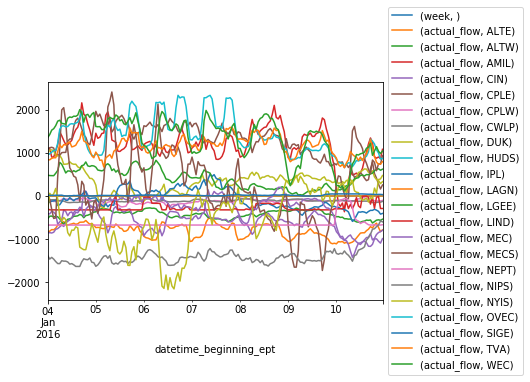

In [121]:
week1.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));